<a href="https://colab.research.google.com/github/jeffeuxMartin/CodingTipsForShare/blob/main/Deep_learning_with_Keras_(modified_by_Jeff_Chen).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基本神經網路架構 - binary classifier
modified by Jeff Chen

In [1]:
import numpy as np, pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

## 創造資料

首先隨機創造一些假的data:

100筆資料，每筆資料是長度為3的tensor
類別只有0和1

In [2]:
# fix random seed
np.random.seed(42)

In [3]:
# training set
x_train = np.random.random((100, 3))
y_train = np.random.randint(0, 2, (100,))

# validation set
x_valid = np.random.random((100, 3))
y_valid = np.random.randint(0, 2, (100,))

觀測生成出來的假資料

In [4]:
print(x_train[:5])
print(y_train[:5])

[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501]
 [0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497]]
[0 1 1 1 0]


## Two common Model definition methods: <br />Sequential Model (Layer-wise) / Functional API (Tensor-wise)

關於定義 model 的方式，主要有兩個角度

1. **Layer-wise** / Sequential Model: 把 model 視為一層一層的 layers，將這些層排成一個 list 組成整個 model （這部分比較接近 Keras 的思維）
1. **Tensor-wise** / Functional API: 把 model 視為一個一個 tensor 互相接起來的 graph（一堆點和線的集合），將這些 tensor 的傳遞告訴 Keras 組成整個 model（這部分思維比較接近 TensorFlow。顧名思義，「Tensor」的「Flow」）


### What is a *layer* exactly?

In [5]:
# 定義一個 layer，代表一排 neurons
fully_connected_layer = layers.Dense(16)  # 16 個 neuron 組成的一層

In [6]:
input_tensor: np.ndarray = np.random.rand(100, 7)
print(input_tensor.shape)   # shape = (100, 7)

(100, 7)


In [7]:
# 一層 fully connected layer 等於會進行一個矩陣運算，\
#     因此出來的 output tensor 的 shape 會是 \
#     (100, num_neurons) 也就是 (100, 16)
output_tensor = fully_connected_layer(input_tensor)
print(output_tensor.shape)  # shape = (100, 16)

# 之所以不用定義 layer 的 input_shape 是因為當張量被傳進 layer 時，layer 自己會知道 shape

(100, 16)


### 接著就處理 model 的建立

### Layer-wise (Sequential model / Sequential API)

#### Method 1: 把 layer 一個一個加到模型裡面

In [8]:
model_from_empty = keras.Sequential()

In [9]:
# 比較不一樣的是，因為整個模型後面在 compile 時需要知道 input_shape 才能 compile，因此在這邊要
# 先 specify input_shape，不然 model 不會先被 build 起來
model_from_empty.add(layers.Dense(16, input_shape=(3,))) #16個neurons
model_from_empty.add(layers.Dense(16)) #16個neurons
model_from_empty.add(layers.Dense(2, activation='sigmoid')) #將輸出壓縮至0-1之間

#compile
model_from_empty.compile(loss='binary_crossentropy', #loss function
              optimizer='adam', 
              metrics=['accuracy'])

In [10]:
model_from_empty.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 370
Trainable params: 370
Non-trainable params: 0
_________________________________________________________________


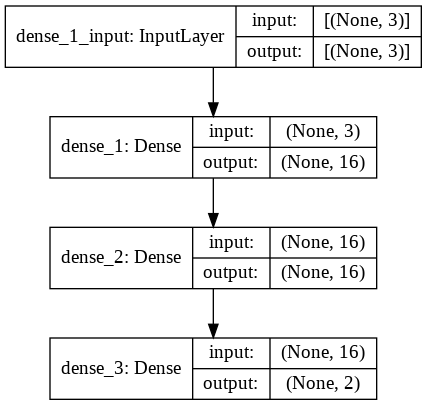

In [11]:
plot_model(model_from_empty, show_shapes=True)

#### Method 2: 把要加的 layers 用成一個 list 一次加到模型裡面
Note: 後面要再新加也是可以的！

In [12]:
model_from_list = keras.Sequential([
    # 跟 method 1 一樣，因為整個模型後面在 compile 時需要知道 input_shape 才能 compile，因此在這邊要
    # 先 specify input_shape，不然 model 不會先被 build 起來
    layers.Dense(16, input_shape=(3,)),
    layers.Dense(16),
    layers.Dense(2, activation='sigmoid')
])

#compile
model_from_list.compile(loss='binary_crossentropy', #loss function
              optimizer='adam', 
              metrics=['accuracy'])

In [13]:
model_from_list.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
Total params: 370
Trainable params: 370
Non-trainable params: 0
_________________________________________________________________


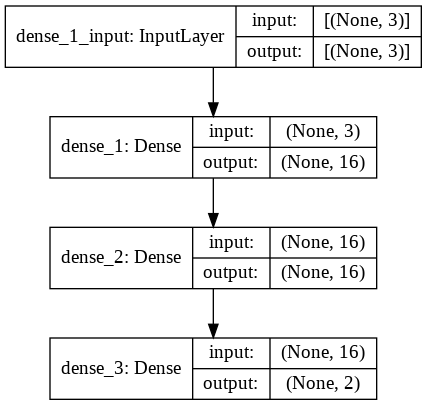

In [14]:
plot_model(model_from_empty, show_shapes=True)

### Tensor-wise (Funtional API): 給定一個 Tensor，接下來把 tensor 傳進去

優點： 比較彈性（讓 Keras 擁有 TensorFlow 與 PyTorch 般的彈性）

缺點： 可能比較難懂難理解，至少會用到類似 graph 的概念 （或者能夠有個「骨架」的概念）

附上 TensorFlow 1.x 的寫法作為與 **Functional API** 的對比，當然這種寫法就是比較非人類，可能因此 Google 才想把比較噁心的程式碼用 Keras Functional API 重新包裝，推出 TensorFlow 2.0。因為 Keras 的寫法比較直觀，但對電腦來說運作是一樣的。

```python
# inputs 是一個 tensor，當作一個空殼，裡面之後可以擺真實的數據進去（就是先放個入口，以便建立骨架）
# inputs = keras.Input(shape=(3,))    <-- Keras          
inputs = tf.placeholder("float", shape=[None, 3])
# # nothing, Keras 會自動幫你算       <-- Keras 
outputs = tf.placeholder("float", shape=[None, 2])

# 接下來，就是把 tensor 每層出來的東西「接起來」
# dense1 = layers.Dense(16)(inputs)   <-- Keras           
dense1 = tf.layers.dense(inputs, 16)
# 現在 dense1 是「經過了 inputs 這層被產生出來的 tensor」
# 接著就是往下餵
# dense2 = layers.Dense(16)(dense1)   <-- Keras           
dense2 = tf.layers.dense(dense1, 16)
# outputs = layers.Dense(2)(dense2)   <-- Keras           
outputs = tf.layers.dense(dense2, 2)
```

差別是，TensorFlow 還要刻一堆這種東西


###### 不要看，你會怕 (X

```python
loss = compute_tf_loss(outputs, answers)

optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)
init_op = tf.global_variables_initializer()

def compute_tf_loss(outputs, answers):
    # ...
    pass

def get_batch(x_data, y_data):
    # ...
    pass

with tf.Session() as session:
    session.run(init_op)
    for epoch in range(200):
        x_data, y_data = get_batch(x_data, y_data)
        session.run(train_op, feed_dict={
            inputs: inputs, outputs: outputs})
```

##### 如果可以理解這種精神（不用理解 TensorFlow 的寫法，理解精神就好），就可以重新看 Function API 的作法了

In [15]:
# inputs 是一個 tensor，當作一個空殼，裡面之後可以擺真實的數據進去（就是先放個入口，以便建立骨架）
inputs = keras.Input(shape=(3,))

In [16]:
# 接下來，就是把 tensor 每層出來的東西「接起來」
dense1 = layers.Dense(16)(inputs)
# 現在 dense1 是「經過了 inputs 這層被產生出來的 tensor」
# 接著就是往下餵

dense2 = layers.Dense(16)(dense1)
outputs = layers.Dense(2)(dense2)

model_from_tensor = keras.Model(inputs=inputs, outputs=outputs)

#compile
model_from_tensor.compile(loss='binary_crossentropy', #loss function
              optimizer='adam', 
              metrics=['accuracy'])

In [17]:
model_from_tensor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 370
Trainable params: 370
Non-trainable params: 0
_________________________________________________________________


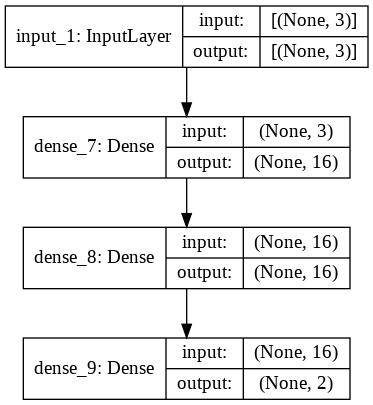

In [18]:
plot_model(model_from_tensor, show_shapes=True)

### 請注意，三種方式建立出來的 model 架構是 **一模一樣** 的
也都可以 summary 跟 plot_model

###### **好習慣** ： 在開始跑之前，建議都先 model.summary() 一下確認自己建立的模型是正確的

## 訓練 Model

在這邊三個 model 都跑下去，證明它們真的是一樣的

In [19]:
# 這邊有一個 Keras 的 bug，就是 functional API 裡面 \
#     binary_crossentropy loss 那邊它會自己幫你轉 one-hot
history__from_empty = model_from_empty.fit(x_train,
                    to_categorical(y_train),
                    batch_size=10,
                    epochs=30,
                    validation_data=(x_valid, 
                                     to_categorical(y_valid)))

Epoch 1/30
10/10 [==============================] - 1s 19ms/step - loss: 0.6985 - accuracy: 0.4700 - val_loss: 0.6930 - val_accuracy: 0.4800
Epoch 2/30
10/10 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.5100 - val_loss: 0.6904 - val_accuracy: 0.5200
Epoch 3/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5300 - val_loss: 0.6887 - val_accuracy: 0.5700
Epoch 4/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5400 - val_loss: 0.6880 - val_accuracy: 0.5500
Epoch 5/30
10/10 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5400 - val_loss: 0.6873 - val_accuracy: 0.5500
Epoch 6/30
10/10 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.5400 - val_loss: 0.6871 - val_accuracy: 0.5500
Epoch 7/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5400 - val_loss: 0.6869 - val_accuracy: 0.5500
Epoch 8/30
10/10 [=

In [20]:
# 這邊有一個 Keras 的 bug，就是 functional API 裡面 \
#     binary_crossentropy loss 那邊它會自己幫你轉 one-hot
history__from_list = model_from_list.fit(x_train,
                    to_categorical(y_train),
                    batch_size=10,
                    epochs=30,
                    validation_data=(x_valid, 
                                     to_categorical(y_valid)))

Epoch 1/30
10/10 [==============================] - 0s 16ms/step - loss: 0.7144 - accuracy: 0.5400 - val_loss: 0.7020 - val_accuracy: 0.5500
Epoch 2/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.5400 - val_loss: 0.6926 - val_accuracy: 0.5500
Epoch 3/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5400 - val_loss: 0.6907 - val_accuracy: 0.5500
Epoch 4/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5400 - val_loss: 0.6899 - val_accuracy: 0.5500
Epoch 5/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5400 - val_loss: 0.6891 - val_accuracy: 0.5500
Epoch 6/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5400 - val_loss: 0.6884 - val_accuracy: 0.5500
Epoch 7/30
10/10 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5400 - val_loss: 0.6880 - val_accuracy: 0.5500
Epoch 8/30
10/10 [=

In [21]:
history__from_tensor = model_from_tensor.fit(x_train,
                    y_train,
                    batch_size=10,
                    epochs=30,
                    validation_data=(x_valid, y_valid))

Epoch 1/30
10/10 [==============================] - 1s 18ms/step - loss: 3.7253 - accuracy: 0.5400 - val_loss: 3.1559 - val_accuracy: 0.5700
Epoch 2/30
10/10 [==============================] - 0s 6ms/step - loss: 2.4988 - accuracy: 0.5400 - val_loss: 1.3870 - val_accuracy: 0.5400
Epoch 3/30
10/10 [==============================] - 0s 6ms/step - loss: 1.1103 - accuracy: 0.4400 - val_loss: 0.7778 - val_accuracy: 0.4600
Epoch 4/30
10/10 [==============================] - 0s 4ms/step - loss: 0.7435 - accuracy: 0.4800 - val_loss: 0.8521 - val_accuracy: 0.5200
Epoch 5/30
10/10 [==============================] - 0s 5ms/step - loss: 0.7490 - accuracy: 0.4700 - val_loss: 0.9225 - val_accuracy: 0.5500
Epoch 6/30
10/10 [==============================] - 0s 5ms/step - loss: 0.7355 - accuracy: 0.4900 - val_loss: 0.7738 - val_accuracy: 0.5200
Epoch 7/30
10/10 [==============================] - 0s 4ms/step - loss: 0.7242 - accuracy: 0.4800 - val_loss: 0.7510 - val_accuracy: 0.5200
Epoch 8/30
10/10 [=

In [22]:
# 然後你也可以只取一個出來訓練
model = model_from_tensor

y_train_target = y_train if model == model_from_tensor else to_categorical(y_train)
y_valid_target = y_valid if model == model_from_tensor else to_categorical(y_valid)

history = model.fit(x_train,
                    y_train_target,
                    batch_size=10,
                    epochs=30,
                    validation_data=(x_valid, y_valid_target))

Epoch 1/30
10/10 [==============================] - 0s 8ms/step - loss: 0.6889 - accuracy: 0.4800 - val_loss: 0.7063 - val_accuracy: 0.5500
Epoch 2/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.4700 - val_loss: 0.7051 - val_accuracy: 0.5500
Epoch 3/30
10/10 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.4700 - val_loss: 0.7050 - val_accuracy: 0.5500
Epoch 4/30
10/10 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.4700 - val_loss: 0.7044 - val_accuracy: 0.5500
Epoch 5/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.4700 - val_loss: 0.7042 - val_accuracy: 0.5600
Epoch 6/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.4800 - val_loss: 0.7029 - val_accuracy: 0.5500
Epoch 7/30
10/10 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.4900 - val_loss: 0.7024 - val_accuracy: 0.5600
Epoch 8/30
10/10 [==

## Accuracy and loss evaluation

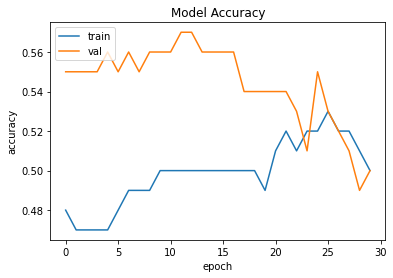

In [23]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

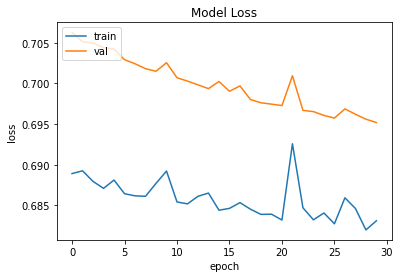

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
history = history__from_empty

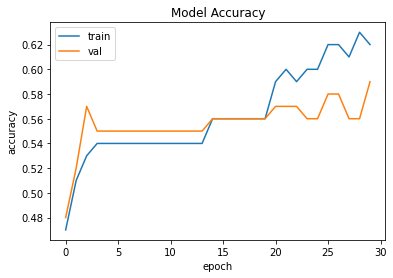

In [26]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

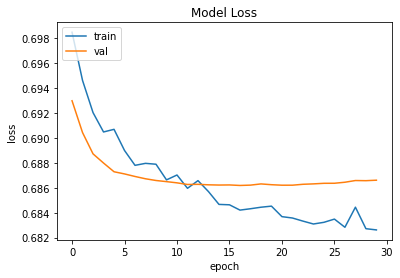

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
history = history__from_list

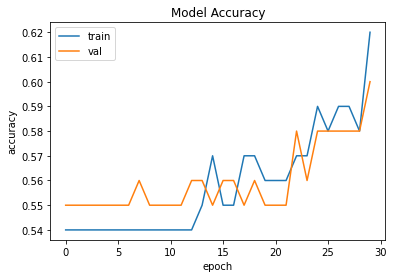

In [29]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

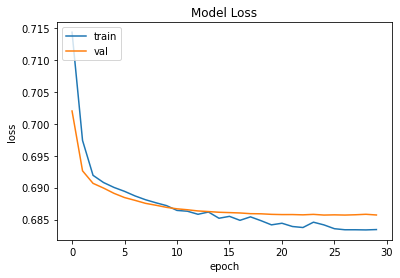

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
history = history__from_tensor

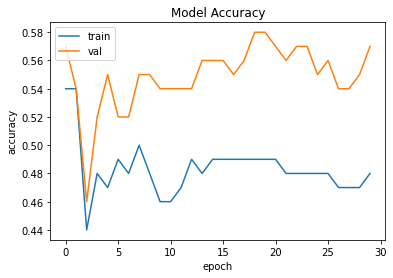

In [32]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

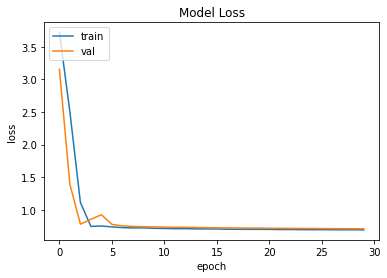

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()